In [17]:
# Классификация изображений CIFAR‑10 с помощью PyTorch
# https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Обучается на:", device)

Обучается на: cpu


In [18]:
# Определяем значения для нормализации
loader_for_stats = torch.utils.data.DataLoader(train_dataset, batch_size=50000, shuffle=False)

data_for_stats = next(iter(loader_for_stats))[0]  # shape: [50000, 3, 32, 32]

mean = data_for_stats.mean(dim=[0, 2, 3])
std = data_for_stats.std(dim=[0, 2, 3])

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.9446, 1.0110, 1.0273])
Std: tensor([0.6017, 0.6007, 0.5744])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04188052..2.2586274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04188052..2.2586274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04188052..2.275574].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04188052..1.9932828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04188052..2.216261].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04188052..2.1433907].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04188052.

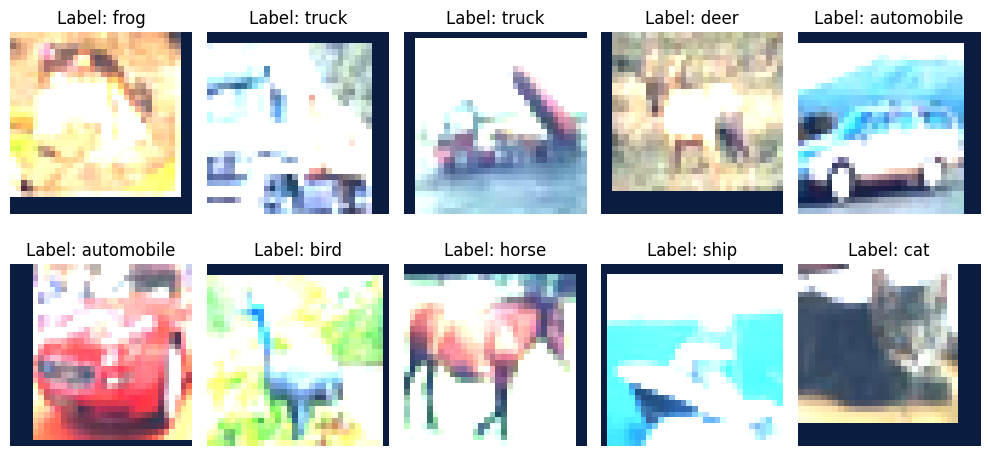

In [19]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images = [train_dataset[i][0] for i in range(10)]
labels = [train_dataset[i][1] for i in range(10)]

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    img = images[i].permute(1, 2, 0)  # Convert from [C, H, W] to [H, W, C] for plotting
    ax.imshow(img)
    ax.set_title(f'Label: {class_names[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std), 
])

train_dataset = torchvision.datasets.CIFAR10(root='./data_cifar10', train=True, transform=transform_train, download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data_cifar10', train=False, transform=transform_test, download=True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=32, shuffle=False)

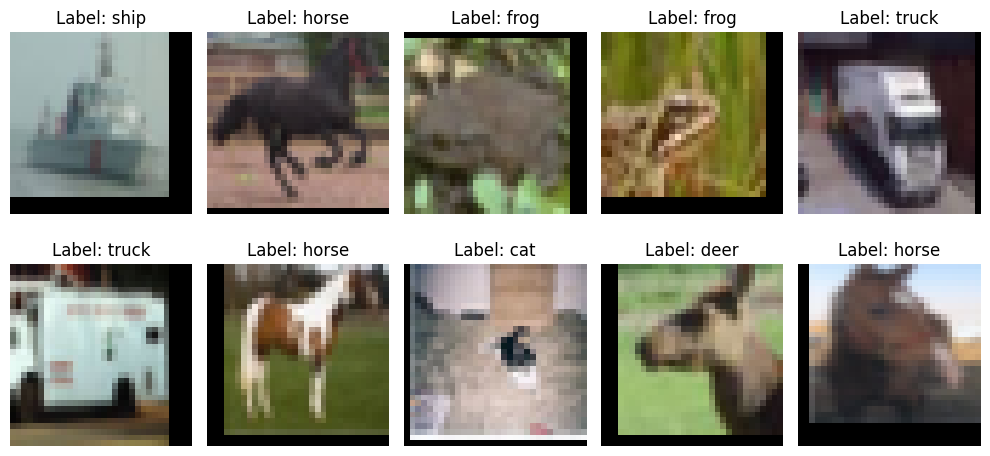

In [21]:
# Обучающий датасет с аугментацией
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot using matplotlib
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    img = images[i] * std.view(3, 1, 1) + mean.view(3, 1, 1) # Unnormalize images for display
    img = img.permute(1, 2, 0) 
    ax.imshow(img)
    ax.set_title(f'Label: {class_names[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [23]:
class SimpleCNN(nn.Module):
    def __init__ (self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fcs2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 8 * 8)

        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fcs2(x)

        return x

model = SimpleCNN()

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15

train_accs = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0 #
    correct = 0 
    total = 0 

    # Loop over batches of data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Clear old gradients from the previous batches
        ## Prevents accumulation of gradients across batches
        optimizer.zero_grad()

        # Forward pass: Feeding the batch to the model
        outputs = model(images)
        # Computing loss by comparing model outputs to true labels
        loss = criterion(outputs, labels)
        # Backpropagation to compute gradients of the loss with respect to model parameters
        ## These gradients tell the model how to adjust its weights to reduce the loss
        loss.backward()
        # Applying weight update to the model's parameters using the optimizer
        optimizer.step()

        # Add the current batch loss to running loss
        running_loss += loss.item()
        # Get the predicted class by finding the index of the max log-probability
        _, predicted = outputs.max(1) # The underscore (_) is used to ignore the first output (max values), we only need the indices

        # Add the number of samples in the current batch to total
        total += labels.size(0)
        # Add the number of correct predictions in the current batch to correct
        correct += predicted.eq(labels).sum().item()

    # Calculate the training accuracy as a percentage and append to the list
    train_acc = 100. * correct / total
    train_accs.append(train_acc)

    # Calculate the average loss over all batches in the epoch and append to the list
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_acc:.2f}%')

Epoch [1/15], Loss: 1.6144, Training Accuracy: 40.93%
Epoch [2/15], Loss: 1.2884, Training Accuracy: 53.51%
Epoch [3/15], Loss: 1.1688, Training Accuracy: 58.16%
Epoch [4/15], Loss: 1.0902, Training Accuracy: 61.22%
Epoch [5/15], Loss: 1.0377, Training Accuracy: 63.23%
Epoch [6/15], Loss: 0.9969, Training Accuracy: 64.75%
Epoch [7/15], Loss: 0.9629, Training Accuracy: 66.04%
Epoch [8/15], Loss: 0.9401, Training Accuracy: 66.81%
Epoch [9/15], Loss: 0.9149, Training Accuracy: 67.71%
Epoch [10/15], Loss: 0.9006, Training Accuracy: 68.42%
Epoch [11/15], Loss: 0.8815, Training Accuracy: 68.69%
Epoch [12/15], Loss: 0.8695, Training Accuracy: 69.37%
Epoch [13/15], Loss: 0.8526, Training Accuracy: 69.79%
Epoch [14/15], Loss: 0.8399, Training Accuracy: 70.33%
Epoch [15/15], Loss: 0.8287, Training Accuracy: 70.91%


In [25]:
model.eval()

correct = 0 # To count correct predictions
total = 0 # To count total samples

# Evaluate the model on the test dataset without computing gradients
with torch.no_grad(): # No need to compute gradients during evaluation
    for images, labels in test_loader:
        # Move images and labels to the device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        # Apply the model to get outputs
        outputs = model(images)
        # Get the predicted class by finding the index of the max log-probability
        _, predicted = outputs.max(1)
        # Add the number of samples in the current batch to total
        total += labels.size(0)
        # Add the number of correct predictions in the current batch to correct
        correct += predicted.eq(labels).sum().item()
# Calculate the test accuracy as a percentage and print it
test_acc = 100. * correct / total
print(f'Test Accuracy: {test_acc:.2f}%')

Test Accuracy: 71.68%


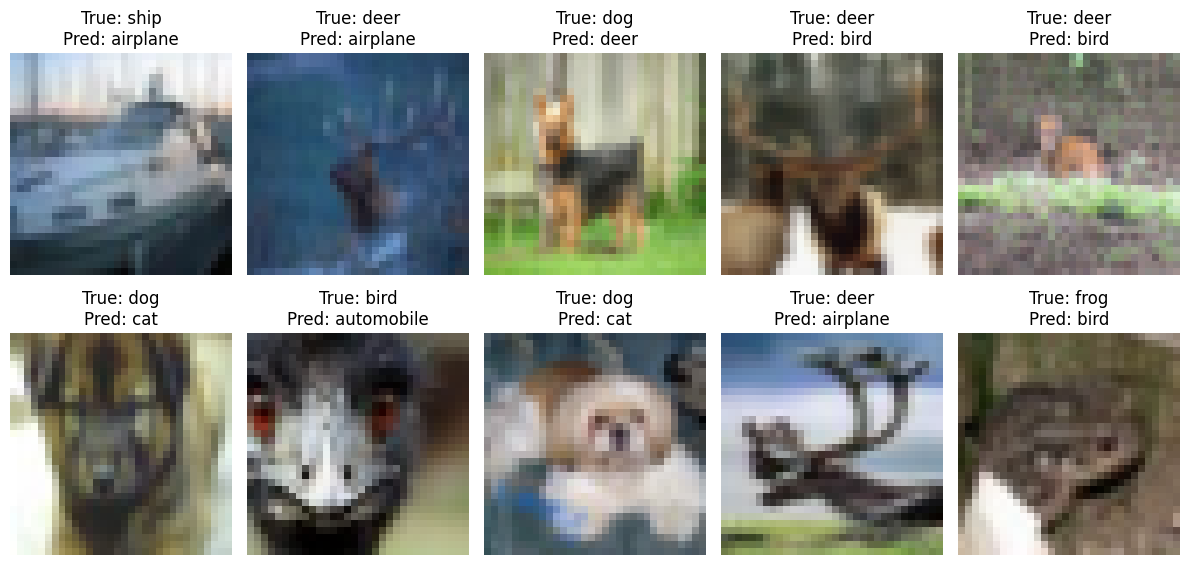

In [26]:
misclassified = []

# Initialize model for evaluation
model.eval()
# Evaluate the model on the test dataset without computing gradients as above
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified.append((images[i].cpu(), predicted[i].cpu(), labels[i].cpu()))
            if len(misclassified) >= 10: # Keep collecting misclassified images until we have 10
                break
        if len(misclassified) >= 10: # Keep collecting misclassified images until we have 10
            break

# Plot the first 10 misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    img, pred, true = misclassified[i]
    ax.imshow(img.permute(1, 2, 0) * std + mean) # Unnormalize for display and convert from [C, H, W] to [H, W, C]
    ax.set_title(f'True: {class_names[true]}\nPred: {class_names[pred]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

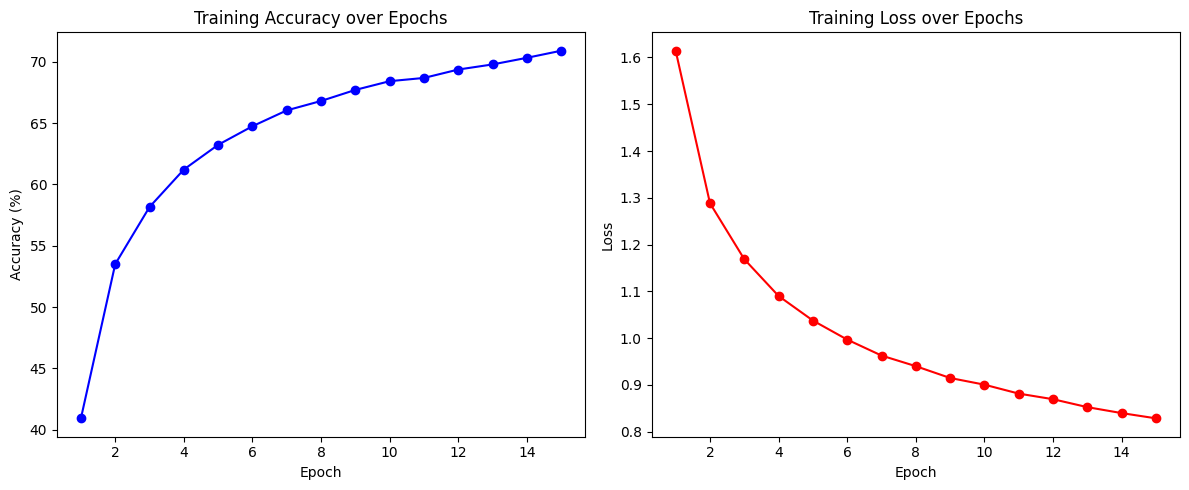

In [27]:
epochs = list(range(1, 16)) # The base model had 15 epochs

train_accs_plot = train_accs # Use training accuracies from the base model
train_losses_plot = train_losses # Use training losses from the base model

plt.figure(figsize=(12, 5))

# Training accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs_plot, marker='o', color='blue')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

# Training loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses_plot, marker='o', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()